In [53]:
result_dict = {'a': 13,
               'b': {'datadir': '/tmp/minst',
                     'batch_size': 1024,
                     'num_workers': 4,
                     'learning_rate': 0.01,
                     'momentum': 0.5,
                     'num_epochs': 20,
                     'num_cores': 8,
                     'log_steps': 20,
                     'metrics_debug': False},
               'c': [1, 2, 4]}
with open('result.json', 'w') as f:
    json.dump(result_dict, f, indent=4, separators=(',', ': '))
#with open('result.json', 'r') as f:
#    d = json.load(f)

'''
json.dumps: dict -> str
json.dump: dict -> file
json.loads: str -> dict
json.load: file -> dict
'''

In [6]:
import json
from pprint import pprint

data = {'a':1, 'b':2, 'c':3, 'd':4, 'e':5}
print(data)
pprint(data)
data2 = json.dumps(data)
pprint(data2)

data2 = json.dumps({'a':'Runoob', 'b':7}, sort_keys=True, indent=4, separators=(',', ': '))
print(data2)
data2 = json.dumps({'a':'Runoob', 'b':7}, sort_keys=True, indent=6, separators=(',', ':'))
print(data2)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5}
'{"a": 1, "b": 2, "c": 3, "d": 4, "e": 5}'
{
    "a": "Runoob",
    "b": 7
}
{
      "a":"Runoob",
      "b":7
}


In [1]:
# train.py
import pandas as pd
import torch
import time
import numpy as np
import warnings
from gensim.models.word2vec import Word2Vec
from model import BatchProgramCC
from sklearn.metrics import precision_recall_fscore_support
warnings.filterwarnings('ignore')

def get_device():
    if torch.cuda.is_available():
        if torch.cuda.get_device_name(0) == 'GeForce GT 730':
            device = 'cpu'
        else:
            device = 'cuda'
    else:
        device = 'cpu'
    return torch.device(device)

device = get_device()

def get_batch(dataset, idx, bs):
    tmp = dataset.iloc[idx: idx+bs]
    x1, x2, labels = [], [], []
    for _, item in tmp.iterrows():
        x1.append(item['code_x'])
        x2.append(item['code_y'])
        labels.append([item['label']])
    return x1, x2, torch.FloatTensor(labels)

def train(model, train_data, batch_size, device, epochs, epoch, optimizer):
    total_acc = 0.0
    total_loss = 0.0
    total = 0.0
    i = 0
    total_trues = 0
    while i < len(train_data):
        train1_inputs, train2_inputs, train_labels = get_batch(train_data, i, batch_size)
        i += len(train_labels)
        train_labels = train_labels.to(device)

        model.zero_grad()
        model.batch_size = len(train_labels)
        model.hidden = model.init_hidden()
        output = model(train1_inputs, train2_inputs)
        #print(output.shape)

        loss = loss_function(output, train_labels)
        loss.backward()
        optimizer.step()

        # acc
        total_loss += loss.item() * len(train_labels)
        predicted = np.where(output.data.cpu().numpy()<0.5, 1, 0)
        total_trues += (predicted==train_labels.cpu().numpy()).sum()
        total_acc = total_trues / i

        print('[Epoch:%3d/%3d] [data: %d/%d] Training Loss: %.4f Training Acc: %.4f%%'
              % (epoch + 1, epochs, i, len(train_data), loss, total_acc*100))
    return total_loss/len(train_data), total_acc

def validation(model, validation_data, batch_size, device, epochs, epoch):
    trues = []
    total_trues = 0
    total_loss = 0.0
    i = 0
    total_trues = 0
    with torch.no_grad():
        while i < len(validation_data):
            validation1_inputs, validation2_inputs, validation_labels = get_batch(validation_data, i, batch_size)
            i += len(validation_labels)
            test_labels = validation_labels.to(device)

            model.batch_size = len(validation_labels)
            model.hidden = model.init_hidden()
            output = model(validation1_inputs, validation2_inputs)

            loss = loss_function(output, validation_labels)

            # calc testing acc
            predicted = (output.data < 0.5).cpu().numpy()
            trues_ex = test_labels.cpu().numpy()
            trues.extend(trues_ex)
            total_trues += np.where(predicted==trues_ex, 1, 0).sum()
            total_loss += loss.item() * len(validation_labels)
    
    total_loss /= len(validation_data)
    total_acc = total_trues / len(validation_data)
    print('[Epoch:%3d/%3d] Validation Loss: %.4f Validation Acc: %.4f%%'
              % (epoch + 1, epochs, total_loss, total_acc*100))
    return total_loss, total_acc

def test(model, test_data, batch_size, device):
    global precision, recall, f1
    predicts = []
    trues = []
    total_trues = 0
    total_loss = 0.0
    i = 0
    total_trues = 0
    with torch.no_grad():
        while i < len(test_data):
            test1_inputs, test2_inputs, test_labels = get_batch(test_data, i, batch_size)
            i += len(test_labels)
            test_labels = test_labels.to(device)

            model.batch_size = len(test_labels)
            model.hidden = model.init_hidden()
            output = model(test1_inputs, test2_inputs)
            loss = loss_function(output, test_labels)

            # calc testing acc
            predicted = (output.data < 0.5).cpu().numpy()
            predicts.extend(predicted)
            trues_ex = test_labels.cpu().numpy()
            trues.extend(trues_ex)
            total_trues += np.where(predicted==trues_ex, 1, 0).sum()
            total_loss += loss.item() * len(test_labels)

    total_acc = total_trues / len(test_data)
    
    if lang == 'java':
        weights = [0, 0.005, 0.001, 0.002, 0.010, 0.982]
        p, r, f, _ = precision_recall_fscore_support(trues, predicts, average='binary')
        precision += weights[t] * p
        recall += weights[t] * r
        f1 += weights[t] * f
        print("Type-" + str(t) + ": " + str(p) + " " + str(r) + " " + str(f))
    else:
        precision, recall, f1, _ = precision_recall_fscore_support(trues, predicts, average='binary')
        print("Testing results(P,R,F1):%.3f, %.3f, %.3f" 
              % (precision, recall, f1))
        
    return total_loss, total_acc, precision, recall, f1

In [3]:
root = 'data/'
lang = 'java'
categories = 1
if lang == 'java':
    categories = 5
print("Train for ", str.upper(lang))
train_data = pd.read_pickle(root+lang+'/train/blocks.pkl').sample(frac=1.0)
validation_data = pd.read_pickle(root+lang+'/dev/blocks.pkl').sample(frac=1.0)
test_data = pd.read_pickle(root+lang+'/test/blocks.pkl').sample(frac=1.0)

word2vec = Word2Vec.load(root+lang+"/train/embedding/node_w2v_128").wv
MAX_TOKENS = word2vec.vectors.shape[0]
EMBEDDING_DIM = word2vec.vectors.shape[1]
embeddings = np.zeros((MAX_TOKENS + 1, EMBEDDING_DIM), dtype="float32")
embeddings[:MAX_TOKENS] = word2vec.vectors

Train for  JAVA


In [2]:
root = 'data/'
lang = 'java'
categories = 1
if lang == 'java':
    categories = 5
print("Train for ", str.upper(lang))
train_data = pd.read_pickle(root+lang+'/train/blocks.pkl').sample(frac=1.0)
validation_data = pd.read_pickle(root+lang+'/dev/blocks.pkl').sample(frac=1.0)
test_data = pd.read_pickle(root+lang+'/test/blocks.pkl').sample(frac=1.0)

from gensim.models.word2vec import Word2Vec
#model= Word2Vec(min_count=4, size=200, workers=6, max_final_vocab=1000000)
#model.load('./word2vec_Model/word2vec')
word2vec = Word2Vec.load('./word2vec_Model/word2vec').wv

MAX_TOKENS = word2vec.vectors.shape[0]
EMBEDDING_DIM = word2vec.vectors.shape[1]
embeddings = np.zeros((MAX_TOKENS + 1, EMBEDDING_DIM), dtype="float32")
embeddings[:MAX_TOKENS] = word2vec.vectors

Train for  JAVA


In [2]:
root = 'data/'
lang = 'java'
categories = 1
if lang == 'java':
    categories = 5
print("Train for ", str.upper(lang))
train_data = pd.read_pickle(root+lang+'/train/blocks.pkl').sample(frac=1.0)
validation_data = pd.read_pickle(root+lang+'/dev/blocks.pkl').sample(frac=1.0)
test_data = pd.read_pickle(root+lang+'/test/blocks.pkl').sample(frac=1.0)

word2vec = Word2Vec.load(root+lang+"/train/embedding/node_w2v_128").wv
MAX_TOKENS = word2vec.vectors.shape[0]
EMBEDDING_DIM = word2vec.vectors.shape[1]
embeddings = np.zeros((MAX_TOKENS + 1, EMBEDDING_DIM), dtype="float32")
embeddings[:MAX_TOKENS] = word2vec.vectors

Train for  JAVA


In [3]:
from torch import nn
from torch.nn import functional as F
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    def forward(self, enclidean_distance, label):
        #enclidean_distance = F.pairwise_distance(output[0], output[1])
        loss_contrastive = torch.mean(label*torch.pow(enclidean_distance, 2) +
                                     (1-label) * torch.pow(torch.clamp(self.margin - enclidean_distance, min=0.0), 2))
        return loss_contrastive


In [4]:

HIDDEN_DIM = 100
ENCODE_DIM = 128
LABELS = 1
EPOCHS = [2,2,5,5,10]
BATCH_SIZE = 128

model = BatchProgramCC(EMBEDDING_DIM,
                       HIDDEN_DIM,
                       MAX_TOKENS+1,
                       ENCODE_DIM,
                       LABELS,
                       BATCH_SIZE,
                       device,
                       embeddings)

model.to(device)

parameters = model.parameters()
optimizer = torch.optim.Adamax(parameters)
#loss_function = torch.nn.BCELoss()
loss_function = ContrastiveLoss(2.0)

best_model_state_dict = model.state_dict()
train_loss = []
val_loss = []
train_acc = []
val_acc = []
test_loss = []
test_acc = []
test_p = []
test_r = []
test_f = []
best_acc = 0.0
precision, recall, f1 = 0, 0, 0
print('Start training...')

for t in range(1, categories+1):
    if lang == 'java':
        train_data_t = train_data[train_data['label'].isin([t, 0])]
        train_data_t.loc[train_data_t['label'] > 0, 'label'] = 1
        
        validation_data_t = validation_data[validation_data['label'].isin([t, 0])]
        validation_data_t.loc[validation_data_t['label'] > 0, 'label'] = 1
        
        test_data_t = test_data[test_data['label'].isin([t, 0])]
        test_data_t.loc[test_data_t['label'] > 0, 'label'] = 1
    else:
        train_data_t, validation_data_t, test_data_t = train_data, validation_data, test_data
    
    for epoch in range(0, EPOCHS[t-1]):
        start_time = time.time()
        model.train()
        total_loss, total_acc = train(model, train_data_t, BATCH_SIZE, device, EPOCHS[t-1], epoch, optimizer)
        train_loss.append(total_loss)
        train_acc.append(total_acc)
        
        print("Testing-%d..."%t)
        model.eval()
        total_loss, total_acc = validation(model, validation_data_t, BATCH_SIZE, device, EPOCHS[t-1], epoch)
        val_loss.append(total_loss)
        val_acc.append(total_acc)
        
        if total_acc > best_acc:
            best_acc = total_acc
            best_model_state_dict = model.state_dict()
            
        end_time = time.time()
        print("Time used: {}s".format(end_time-start_time))
    
    torch.save(model.state_dict(), 'code_clone_detection_java_model_train_with_ContrastiveLoss_on_java_label_' + str(t) + '_epoch_' + str(EPOCHS[t-1]) + '.pt')
    total_loss, total_acc, precision, recall, f1 = test(model, test_data_t, BATCH_SIZE, device)
    test_loss.append(total_loss)
    test_acc.append(total_acc)
    test_p.append(precision)
    test_r.append(recall)
    test_f.append(f1)


#torch.save(model.state_dict(), 'code_clone_detection_java_model_train_on_30_percent.pt')
#model.load_state_dict(best_model_state_dict)
#model.eval()
#test(model, test_data, BATCH_SIZE*2, device)
#print("Total testing results(P,R,F1):%.3f, %.3f, %.3f" % (precision, recall, f1))

#torch.save(model.state_dict(), 'code_clone_detection_model.pt')

Start training...
[Epoch:  1/  2] [data: 128/21362] Training Loss: 0.1335 Training Acc: 84.3750%
[Epoch:  1/  2] [data: 256/21362] Training Loss: 0.0271 Training Acc: 92.1875%
[Epoch:  1/  2] [data: 384/21362] Training Loss: 0.0038 Training Acc: 94.7917%
[Epoch:  1/  2] [data: 512/21362] Training Loss: 0.0006 Training Acc: 96.0938%
[Epoch:  1/  2] [data: 640/21362] Training Loss: 0.0037 Training Acc: 96.8750%
[Epoch:  1/  2] [data: 768/21362] Training Loss: 0.0037 Training Acc: 97.3958%
[Epoch:  1/  2] [data: 896/21362] Training Loss: 0.0002 Training Acc: 97.7679%
[Epoch:  1/  2] [data: 1024/21362] Training Loss: 0.0001 Training Acc: 98.0469%
[Epoch:  1/  2] [data: 1152/21362] Training Loss: 0.0001 Training Acc: 98.2639%
[Epoch:  1/  2] [data: 1280/21362] Training Loss: 0.0000 Training Acc: 98.4375%
[Epoch:  1/  2] [data: 1408/21362] Training Loss: 0.0001 Training Acc: 98.5795%
[Epoch:  1/  2] [data: 1536/21362] Training Loss: 0.0027 Training Acc: 98.6979%
[Epoch:  1/  2] [data: 1664/2

[Epoch:  1/  2] [data: 13184/21362] Training Loss: 0.0000 Training Acc: 99.8483%
[Epoch:  1/  2] [data: 13312/21362] Training Loss: 0.0000 Training Acc: 99.8498%
[Epoch:  1/  2] [data: 13440/21362] Training Loss: 0.0000 Training Acc: 99.8512%
[Epoch:  1/  2] [data: 13568/21362] Training Loss: 0.0000 Training Acc: 99.8526%
[Epoch:  1/  2] [data: 13696/21362] Training Loss: 0.0000 Training Acc: 99.8540%
[Epoch:  1/  2] [data: 13824/21362] Training Loss: 0.0000 Training Acc: 99.8553%
[Epoch:  1/  2] [data: 13952/21362] Training Loss: 0.0000 Training Acc: 99.8567%
[Epoch:  1/  2] [data: 14080/21362] Training Loss: 0.0000 Training Acc: 99.8580%
[Epoch:  1/  2] [data: 14208/21362] Training Loss: 0.0006 Training Acc: 99.8592%
[Epoch:  1/  2] [data: 14336/21362] Training Loss: 0.0000 Training Acc: 99.8605%
[Epoch:  1/  2] [data: 14464/21362] Training Loss: 0.0000 Training Acc: 99.8617%
[Epoch:  1/  2] [data: 14592/21362] Training Loss: 0.0000 Training Acc: 99.8629%
[Epoch:  1/  2] [data: 14720

[Epoch:  2/  2] [data: 4608/21362] Training Loss: 0.0000 Training Acc: 100.0000%
[Epoch:  2/  2] [data: 4736/21362] Training Loss: 0.0000 Training Acc: 100.0000%
[Epoch:  2/  2] [data: 4864/21362] Training Loss: 0.0000 Training Acc: 100.0000%
[Epoch:  2/  2] [data: 4992/21362] Training Loss: 0.0000 Training Acc: 100.0000%
[Epoch:  2/  2] [data: 5120/21362] Training Loss: 0.0000 Training Acc: 100.0000%
[Epoch:  2/  2] [data: 5248/21362] Training Loss: 0.0000 Training Acc: 100.0000%
[Epoch:  2/  2] [data: 5376/21362] Training Loss: 0.0000 Training Acc: 100.0000%
[Epoch:  2/  2] [data: 5504/21362] Training Loss: 0.0000 Training Acc: 100.0000%
[Epoch:  2/  2] [data: 5632/21362] Training Loss: 0.0000 Training Acc: 100.0000%
[Epoch:  2/  2] [data: 5760/21362] Training Loss: 0.0000 Training Acc: 100.0000%
[Epoch:  2/  2] [data: 5888/21362] Training Loss: 0.0000 Training Acc: 100.0000%
[Epoch:  2/  2] [data: 6016/21362] Training Loss: 0.0000 Training Acc: 100.0000%
[Epoch:  2/  2] [data: 6144/

[Epoch:  2/  2] [data: 17536/21362] Training Loss: 0.0000 Training Acc: 100.0000%
[Epoch:  2/  2] [data: 17664/21362] Training Loss: 0.0000 Training Acc: 100.0000%
[Epoch:  2/  2] [data: 17792/21362] Training Loss: 0.0000 Training Acc: 100.0000%
[Epoch:  2/  2] [data: 17920/21362] Training Loss: 0.0000 Training Acc: 100.0000%
[Epoch:  2/  2] [data: 18048/21362] Training Loss: 0.0000 Training Acc: 100.0000%
[Epoch:  2/  2] [data: 18176/21362] Training Loss: 0.0000 Training Acc: 100.0000%
[Epoch:  2/  2] [data: 18304/21362] Training Loss: 0.0000 Training Acc: 100.0000%
[Epoch:  2/  2] [data: 18432/21362] Training Loss: 0.0000 Training Acc: 100.0000%
[Epoch:  2/  2] [data: 18560/21362] Training Loss: 0.0000 Training Acc: 100.0000%
[Epoch:  2/  2] [data: 18688/21362] Training Loss: 0.0000 Training Acc: 100.0000%
[Epoch:  2/  2] [data: 18816/21362] Training Loss: 0.0000 Training Acc: 100.0000%
[Epoch:  2/  2] [data: 18944/21362] Training Loss: 0.0000 Training Acc: 100.0000%
[Epoch:  2/  2] 

[Epoch:  1/  2] [data: 9088/14329] Training Loss: 0.0025 Training Acc: 99.5489%
[Epoch:  1/  2] [data: 9216/14329] Training Loss: 0.0007 Training Acc: 99.5551%
[Epoch:  1/  2] [data: 9344/14329] Training Loss: 0.0006 Training Acc: 99.5612%
[Epoch:  1/  2] [data: 9472/14329] Training Loss: 0.0075 Training Acc: 99.5566%
[Epoch:  1/  2] [data: 9600/14329] Training Loss: 0.0006 Training Acc: 99.5625%
[Epoch:  1/  2] [data: 9728/14329] Training Loss: 0.0031 Training Acc: 99.5683%
[Epoch:  1/  2] [data: 9856/14329] Training Loss: 0.0014 Training Acc: 99.5739%
[Epoch:  1/  2] [data: 9984/14329] Training Loss: 0.0048 Training Acc: 99.5693%
[Epoch:  1/  2] [data: 10112/14329] Training Loss: 0.0016 Training Acc: 99.5748%
[Epoch:  1/  2] [data: 10240/14329] Training Loss: 0.0104 Training Acc: 99.5801%
[Epoch:  1/  2] [data: 10368/14329] Training Loss: 0.0049 Training Acc: 99.5756%
[Epoch:  1/  2] [data: 10496/14329] Training Loss: 0.0016 Training Acc: 99.5808%
[Epoch:  1/  2] [data: 10624/14329] 

[Epoch:  2/  2] [data: 7680/14329] Training Loss: 0.0001 Training Acc: 99.9089%
[Epoch:  2/  2] [data: 7808/14329] Training Loss: 0.0019 Training Acc: 99.9103%
[Epoch:  2/  2] [data: 7936/14329] Training Loss: 0.0018 Training Acc: 99.9118%
[Epoch:  2/  2] [data: 8064/14329] Training Loss: 0.0007 Training Acc: 99.9132%
[Epoch:  2/  2] [data: 8192/14329] Training Loss: 0.0007 Training Acc: 99.9146%
[Epoch:  2/  2] [data: 8320/14329] Training Loss: 0.0002 Training Acc: 99.9159%
[Epoch:  2/  2] [data: 8448/14329] Training Loss: 0.0014 Training Acc: 99.9171%
[Epoch:  2/  2] [data: 8576/14329] Training Loss: 0.0020 Training Acc: 99.9184%
[Epoch:  2/  2] [data: 8704/14329] Training Loss: 0.0003 Training Acc: 99.9196%
[Epoch:  2/  2] [data: 8832/14329] Training Loss: 0.0026 Training Acc: 99.9094%
[Epoch:  2/  2] [data: 8960/14329] Training Loss: 0.0004 Training Acc: 99.9107%
[Epoch:  2/  2] [data: 9088/14329] Training Loss: 0.0009 Training Acc: 99.9120%
[Epoch:  2/  2] [data: 9216/14329] Train

[Epoch:  1/  2] [data: 6272/23054] Training Loss: 0.1925 Training Acc: 84.3591%
[Epoch:  1/  2] [data: 6400/23054] Training Loss: 0.1908 Training Acc: 84.5781%
[Epoch:  1/  2] [data: 6528/23054] Training Loss: 0.2214 Training Acc: 84.7426%
[Epoch:  1/  2] [data: 6656/23054] Training Loss: 0.2975 Training Acc: 84.8708%
[Epoch:  1/  2] [data: 6784/23054] Training Loss: 0.1214 Training Acc: 85.0678%
[Epoch:  1/  2] [data: 6912/23054] Training Loss: 0.1964 Training Acc: 85.2141%
[Epoch:  1/  2] [data: 7040/23054] Training Loss: 0.1474 Training Acc: 85.4261%
[Epoch:  1/  2] [data: 7168/23054] Training Loss: 0.1078 Training Acc: 85.6445%
[Epoch:  1/  2] [data: 7296/23054] Training Loss: 0.2490 Training Acc: 85.8004%
[Epoch:  1/  2] [data: 7424/23054] Training Loss: 0.1400 Training Acc: 85.9914%
[Epoch:  1/  2] [data: 7552/23054] Training Loss: 0.1672 Training Acc: 86.1494%
[Epoch:  1/  2] [data: 7680/23054] Training Loss: 0.1472 Training Acc: 86.3151%
[Epoch:  1/  2] [data: 7808/23054] Train

[Epoch:  1/  2] [data: 19328/23054] Training Loss: 0.1859 Training Acc: 91.4114%
[Epoch:  1/  2] [data: 19456/23054] Training Loss: 0.1312 Training Acc: 91.4474%
[Epoch:  1/  2] [data: 19584/23054] Training Loss: 0.0989 Training Acc: 91.4828%
[Epoch:  1/  2] [data: 19712/23054] Training Loss: 0.1727 Training Acc: 91.5128%
[Epoch:  1/  2] [data: 19840/23054] Training Loss: 0.1093 Training Acc: 91.5373%
[Epoch:  1/  2] [data: 19968/23054] Training Loss: 0.1740 Training Acc: 91.5715%
[Epoch:  1/  2] [data: 20096/23054] Training Loss: 0.1011 Training Acc: 91.6103%
[Epoch:  1/  2] [data: 20224/23054] Training Loss: 0.0915 Training Acc: 91.6436%
[Epoch:  1/  2] [data: 20352/23054] Training Loss: 0.1668 Training Acc: 91.6618%
[Epoch:  1/  2] [data: 20480/23054] Training Loss: 0.0916 Training Acc: 91.6846%
[Epoch:  1/  2] [data: 20608/23054] Training Loss: 0.2088 Training Acc: 91.6974%
[Epoch:  1/  2] [data: 20736/23054] Training Loss: 0.1076 Training Acc: 91.7149%
[Epoch:  1/  2] [data: 20864

[Epoch:  2/  2] [data: 9088/23054] Training Loss: 0.1135 Training Acc: 96.1928%
[Epoch:  2/  2] [data: 9216/23054] Training Loss: 0.0272 Training Acc: 96.2457%
[Epoch:  2/  2] [data: 9344/23054] Training Loss: 0.1743 Training Acc: 96.2436%
[Epoch:  2/  2] [data: 9472/23054] Training Loss: 0.1085 Training Acc: 96.2204%
[Epoch:  2/  2] [data: 9600/23054] Training Loss: 0.1501 Training Acc: 96.2083%
[Epoch:  2/  2] [data: 9728/23054] Training Loss: 0.0966 Training Acc: 96.2274%
[Epoch:  2/  2] [data: 9856/23054] Training Loss: 0.0946 Training Acc: 96.2561%
[Epoch:  2/  2] [data: 9984/23054] Training Loss: 0.0852 Training Acc: 96.2740%
[Epoch:  2/  2] [data: 10112/23054] Training Loss: 0.1270 Training Acc: 96.2718%
[Epoch:  2/  2] [data: 10240/23054] Training Loss: 0.0587 Training Acc: 96.2988%
[Epoch:  2/  2] [data: 10368/23054] Training Loss: 0.0922 Training Acc: 96.3156%
[Epoch:  2/  2] [data: 10496/23054] Training Loss: 0.1113 Training Acc: 96.3034%
[Epoch:  2/  2] [data: 10624/23054] 

[Epoch:  2/  2] [data: 22144/23054] Training Loss: 0.1413 Training Acc: 96.1299%
[Epoch:  2/  2] [data: 22272/23054] Training Loss: 0.1793 Training Acc: 96.1252%
[Epoch:  2/  2] [data: 22400/23054] Training Loss: 0.1946 Training Acc: 96.1205%
[Epoch:  2/  2] [data: 22528/23054] Training Loss: 0.1563 Training Acc: 96.1159%
[Epoch:  2/  2] [data: 22656/23054] Training Loss: 0.0585 Training Acc: 96.1291%
[Epoch:  2/  2] [data: 22784/23054] Training Loss: 0.0822 Training Acc: 96.1157%
[Epoch:  2/  2] [data: 22912/23054] Training Loss: 0.2099 Training Acc: 96.1112%
[Epoch:  2/  2] [data: 23040/23054] Training Loss: 0.2349 Training Acc: 96.0807%
[Epoch:  2/  2] [data: 23054/23054] Training Loss: 0.2632 Training Acc: 96.0788%
Testing-3...
[Epoch:  2/  2] Validation Loss: 0.1205 Validation Acc: 96.4492%
Time used: 1109.9475662708282s
Type-3: 1.0 0.9126266776225691 0.9543176285264213
[Epoch:  1/  5] [data: 128/24058] Training Loss: 0.2702 Training Acc: 85.1562%
[Epoch:  1/  5] [data: 256/24058]

[Epoch:  1/  5] [data: 11904/24058] Training Loss: 0.1757 Training Acc: 91.0366%
[Epoch:  1/  5] [data: 12032/24058] Training Loss: 0.1775 Training Acc: 91.0738%
[Epoch:  1/  5] [data: 12160/24058] Training Loss: 0.1806 Training Acc: 91.1020%
[Epoch:  1/  5] [data: 12288/24058] Training Loss: 0.1759 Training Acc: 91.1540%
[Epoch:  1/  5] [data: 12416/24058] Training Loss: 0.2805 Training Acc: 91.1485%
[Epoch:  1/  5] [data: 12544/24058] Training Loss: 0.1644 Training Acc: 91.1910%
[Epoch:  1/  5] [data: 12672/24058] Training Loss: 0.2476 Training Acc: 91.1932%
[Epoch:  1/  5] [data: 12800/24058] Training Loss: 0.2447 Training Acc: 91.1875%
[Epoch:  1/  5] [data: 12928/24058] Training Loss: 0.1383 Training Acc: 91.2361%
[Epoch:  1/  5] [data: 13056/24058] Training Loss: 0.2213 Training Acc: 91.2531%
[Epoch:  1/  5] [data: 13184/24058] Training Loss: 0.1988 Training Acc: 91.2849%
[Epoch:  1/  5] [data: 13312/24058] Training Loss: 0.1332 Training Acc: 91.3386%
[Epoch:  1/  5] [data: 13440

[Epoch:  2/  5] [data: 640/24058] Training Loss: 0.2030 Training Acc: 92.0312%
[Epoch:  2/  5] [data: 768/24058] Training Loss: 0.2306 Training Acc: 92.1875%
[Epoch:  2/  5] [data: 896/24058] Training Loss: 0.0916 Training Acc: 92.9688%
[Epoch:  2/  5] [data: 1024/24058] Training Loss: 0.1730 Training Acc: 93.2617%
[Epoch:  2/  5] [data: 1152/24058] Training Loss: 0.1832 Training Acc: 93.4896%
[Epoch:  2/  5] [data: 1280/24058] Training Loss: 0.4563 Training Acc: 92.7344%
[Epoch:  2/  5] [data: 1408/24058] Training Loss: 0.1927 Training Acc: 92.8267%
[Epoch:  2/  5] [data: 1536/24058] Training Loss: 0.0998 Training Acc: 93.1641%
[Epoch:  2/  5] [data: 1664/24058] Training Loss: 0.2702 Training Acc: 93.0889%
[Epoch:  2/  5] [data: 1792/24058] Training Loss: 0.2834 Training Acc: 92.9688%
[Epoch:  2/  5] [data: 1920/24058] Training Loss: 0.1081 Training Acc: 93.2292%
[Epoch:  2/  5] [data: 2048/24058] Training Loss: 0.2084 Training Acc: 93.3105%
[Epoch:  2/  5] [data: 2176/24058] Training

[Epoch:  2/  5] [data: 13824/24058] Training Loss: 0.1355 Training Acc: 94.5530%
[Epoch:  2/  5] [data: 13952/24058] Training Loss: 0.1779 Training Acc: 94.5528%
[Epoch:  2/  5] [data: 14080/24058] Training Loss: 0.1615 Training Acc: 94.5668%
[Epoch:  2/  5] [data: 14208/24058] Training Loss: 0.2702 Training Acc: 94.5312%
[Epoch:  2/  5] [data: 14336/24058] Training Loss: 0.1309 Training Acc: 94.5522%
[Epoch:  2/  5] [data: 14464/24058] Training Loss: 0.0772 Training Acc: 94.5796%
[Epoch:  2/  5] [data: 14592/24058] Training Loss: 0.1787 Training Acc: 94.5861%
[Epoch:  2/  5] [data: 14720/24058] Training Loss: 0.0760 Training Acc: 94.6196%
[Epoch:  2/  5] [data: 14848/24058] Training Loss: 0.1731 Training Acc: 94.6188%
[Epoch:  2/  5] [data: 14976/24058] Training Loss: 0.1530 Training Acc: 94.6314%
[Epoch:  2/  5] [data: 15104/24058] Training Loss: 0.1283 Training Acc: 94.6438%
[Epoch:  2/  5] [data: 15232/24058] Training Loss: 0.1581 Training Acc: 94.6560%
[Epoch:  2/  5] [data: 15360

[Epoch:  3/  5] [data: 2688/24058] Training Loss: 0.0788 Training Acc: 94.3824%
[Epoch:  3/  5] [data: 2816/24058] Training Loss: 0.1706 Training Acc: 94.3537%
[Epoch:  3/  5] [data: 2944/24058] Training Loss: 0.0776 Training Acc: 94.4973%
[Epoch:  3/  5] [data: 3072/24058] Training Loss: 0.2595 Training Acc: 94.4010%
[Epoch:  3/  5] [data: 3200/24058] Training Loss: 0.2038 Training Acc: 94.3750%
[Epoch:  3/  5] [data: 3328/24058] Training Loss: 0.1209 Training Acc: 94.4712%
[Epoch:  3/  5] [data: 3456/24058] Training Loss: 0.1252 Training Acc: 94.5602%
[Epoch:  3/  5] [data: 3584/24058] Training Loss: 0.1066 Training Acc: 94.6429%
[Epoch:  3/  5] [data: 3712/24058] Training Loss: 0.2971 Training Acc: 94.5043%
[Epoch:  3/  5] [data: 3840/24058] Training Loss: 0.0775 Training Acc: 94.6094%
[Epoch:  3/  5] [data: 3968/24058] Training Loss: 0.1269 Training Acc: 94.6825%
[Epoch:  3/  5] [data: 4096/24058] Training Loss: 0.2168 Training Acc: 94.6533%
[Epoch:  3/  5] [data: 4224/24058] Train

[Epoch:  3/  5] [data: 15744/24058] Training Loss: 0.2417 Training Acc: 95.0203%
[Epoch:  3/  5] [data: 15872/24058] Training Loss: 0.1313 Training Acc: 95.0353%
[Epoch:  3/  5] [data: 16000/24058] Training Loss: 0.1893 Training Acc: 95.0375%
[Epoch:  3/  5] [data: 16128/24058] Training Loss: 0.1408 Training Acc: 95.0459%
[Epoch:  3/  5] [data: 16256/24058] Training Loss: 0.2029 Training Acc: 95.0418%
[Epoch:  3/  5] [data: 16384/24058] Training Loss: 0.1933 Training Acc: 95.0439%
[Epoch:  3/  5] [data: 16512/24058] Training Loss: 0.2543 Training Acc: 95.0218%
[Epoch:  3/  5] [data: 16640/24058] Training Loss: 0.1802 Training Acc: 95.0180%
[Epoch:  3/  5] [data: 16768/24058] Training Loss: 0.1325 Training Acc: 95.0322%
[Epoch:  3/  5] [data: 16896/24058] Training Loss: 0.1857 Training Acc: 95.0343%
[Epoch:  3/  5] [data: 17024/24058] Training Loss: 0.2842 Training Acc: 95.0012%
[Epoch:  3/  5] [data: 17152/24058] Training Loss: 0.1778 Training Acc: 94.9977%
[Epoch:  3/  5] [data: 17280

[Epoch:  4/  5] [data: 4608/24058] Training Loss: 0.0657 Training Acc: 94.9653%
[Epoch:  4/  5] [data: 4736/24058] Training Loss: 0.2302 Training Acc: 94.9324%
[Epoch:  4/  5] [data: 4864/24058] Training Loss: 0.0980 Training Acc: 95.0041%
[Epoch:  4/  5] [data: 4992/24058] Training Loss: 0.1058 Training Acc: 95.0321%
[Epoch:  4/  5] [data: 5120/24058] Training Loss: 0.1800 Training Acc: 95.0000%
[Epoch:  4/  5] [data: 5248/24058] Training Loss: 0.1736 Training Acc: 95.0076%
[Epoch:  4/  5] [data: 5376/24058] Training Loss: 0.2000 Training Acc: 94.9963%
[Epoch:  4/  5] [data: 5504/24058] Training Loss: 0.1123 Training Acc: 95.0581%
[Epoch:  4/  5] [data: 5632/24058] Training Loss: 0.1724 Training Acc: 95.0639%
[Epoch:  4/  5] [data: 5760/24058] Training Loss: 0.1544 Training Acc: 95.0694%
[Epoch:  4/  5] [data: 5888/24058] Training Loss: 0.1507 Training Acc: 95.0917%
[Epoch:  4/  5] [data: 6016/24058] Training Loss: 0.1678 Training Acc: 95.0798%
[Epoch:  4/  5] [data: 6144/24058] Train

[Epoch:  4/  5] [data: 17664/24058] Training Loss: 0.1527 Training Acc: 95.0974%
[Epoch:  4/  5] [data: 17792/24058] Training Loss: 0.1440 Training Acc: 95.1045%
[Epoch:  4/  5] [data: 17920/24058] Training Loss: 0.2131 Training Acc: 95.0949%
[Epoch:  4/  5] [data: 18048/24058] Training Loss: 0.1250 Training Acc: 95.1075%
[Epoch:  4/  5] [data: 18176/24058] Training Loss: 0.2821 Training Acc: 95.0814%
[Epoch:  4/  5] [data: 18304/24058] Training Loss: 0.1741 Training Acc: 95.0830%
[Epoch:  4/  5] [data: 18432/24058] Training Loss: 0.1328 Training Acc: 95.0901%
[Epoch:  4/  5] [data: 18560/24058] Training Loss: 0.1826 Training Acc: 95.0862%
[Epoch:  4/  5] [data: 18688/24058] Training Loss: 0.0976 Training Acc: 95.1038%
[Epoch:  4/  5] [data: 18816/24058] Training Loss: 0.1512 Training Acc: 95.1052%
[Epoch:  4/  5] [data: 18944/24058] Training Loss: 0.1781 Training Acc: 95.1066%
[Epoch:  4/  5] [data: 19072/24058] Training Loss: 0.1286 Training Acc: 95.1133%
[Epoch:  4/  5] [data: 19200

[Epoch:  5/  5] [data: 6528/24058] Training Loss: 0.1483 Training Acc: 95.2665%
[Epoch:  5/  5] [data: 6656/24058] Training Loss: 0.1728 Training Acc: 95.2674%
[Epoch:  5/  5] [data: 6784/24058] Training Loss: 0.1244 Training Acc: 95.2978%
[Epoch:  5/  5] [data: 6912/24058] Training Loss: 0.1958 Training Acc: 95.2836%
[Epoch:  5/  5] [data: 7040/24058] Training Loss: 0.1636 Training Acc: 95.2841%
[Epoch:  5/  5] [data: 7168/24058] Training Loss: 0.1840 Training Acc: 95.2846%
[Epoch:  5/  5] [data: 7296/24058] Training Loss: 0.0757 Training Acc: 95.3399%
[Epoch:  5/  5] [data: 7424/24058] Training Loss: 0.1062 Training Acc: 95.3664%
[Epoch:  5/  5] [data: 7552/24058] Training Loss: 0.0714 Training Acc: 95.4052%
[Epoch:  5/  5] [data: 7680/24058] Training Loss: 0.1809 Training Acc: 95.3906%
[Epoch:  5/  5] [data: 7808/24058] Training Loss: 0.1895 Training Acc: 95.3765%
[Epoch:  5/  5] [data: 7936/24058] Training Loss: 0.2968 Training Acc: 95.3251%
[Epoch:  5/  5] [data: 8064/24058] Train

[Epoch:  5/  5] [data: 19584/24058] Training Loss: 0.1014 Training Acc: 95.2614%
[Epoch:  5/  5] [data: 19712/24058] Training Loss: 0.1513 Training Acc: 95.2668%
[Epoch:  5/  5] [data: 19840/24058] Training Loss: 0.1272 Training Acc: 95.2722%
[Epoch:  5/  5] [data: 19968/24058] Training Loss: 0.2007 Training Acc: 95.2624%
[Epoch:  5/  5] [data: 20096/24058] Training Loss: 0.3121 Training Acc: 95.2329%
[Epoch:  5/  5] [data: 20224/24058] Training Loss: 0.2314 Training Acc: 95.2136%
[Epoch:  5/  5] [data: 20352/24058] Training Loss: 0.1273 Training Acc: 95.2191%
[Epoch:  5/  5] [data: 20480/24058] Training Loss: 0.0812 Training Acc: 95.2393%
[Epoch:  5/  5] [data: 20608/24058] Training Loss: 0.2590 Training Acc: 95.2106%
[Epoch:  5/  5] [data: 20736/24058] Training Loss: 0.1208 Training Acc: 95.2160%
[Epoch:  5/  5] [data: 20864/24058] Training Loss: 0.1032 Training Acc: 95.2262%
[Epoch:  5/  5] [data: 20992/24058] Training Loss: 0.1824 Training Acc: 95.2172%
[Epoch:  5/  5] [data: 21120

[Epoch:  1/  5] [data: 8448/24026] Training Loss: 0.2742 Training Acc: 93.6316%
[Epoch:  1/  5] [data: 8576/24026] Training Loss: 0.1814 Training Acc: 93.6567%
[Epoch:  1/  5] [data: 8704/24026] Training Loss: 0.2017 Training Acc: 93.6696%
[Epoch:  1/  5] [data: 8832/24026] Training Loss: 0.1249 Training Acc: 93.7160%
[Epoch:  1/  5] [data: 8960/24026] Training Loss: 0.1536 Training Acc: 93.7500%
[Epoch:  1/  5] [data: 9088/24026] Training Loss: 0.3665 Training Acc: 93.6620%
[Epoch:  1/  5] [data: 9216/24026] Training Loss: 0.1432 Training Acc: 93.6957%
[Epoch:  1/  5] [data: 9344/24026] Training Loss: 0.0941 Training Acc: 93.7607%
[Epoch:  1/  5] [data: 9472/24026] Training Loss: 0.2043 Training Acc: 93.7711%
[Epoch:  1/  5] [data: 9600/24026] Training Loss: 0.2613 Training Acc: 93.7500%
[Epoch:  1/  5] [data: 9728/24026] Training Loss: 0.2555 Training Acc: 93.7397%
[Epoch:  1/  5] [data: 9856/24026] Training Loss: 0.2996 Training Acc: 93.6993%
[Epoch:  1/  5] [data: 9984/24026] Train

[Epoch:  1/  5] [data: 21504/24026] Training Loss: 0.1725 Training Acc: 93.4570%
[Epoch:  1/  5] [data: 21632/24026] Training Loss: 0.1546 Training Acc: 93.4726%
[Epoch:  1/  5] [data: 21760/24026] Training Loss: 0.2521 Training Acc: 93.4651%
[Epoch:  1/  5] [data: 21888/24026] Training Loss: 0.1489 Training Acc: 93.4759%
[Epoch:  1/  5] [data: 22016/24026] Training Loss: 0.2049 Training Acc: 93.4775%
[Epoch:  1/  5] [data: 22144/24026] Training Loss: 0.2109 Training Acc: 93.4836%
[Epoch:  1/  5] [data: 22272/24026] Training Loss: 0.1862 Training Acc: 93.4896%
[Epoch:  1/  5] [data: 22400/24026] Training Loss: 0.2480 Training Acc: 93.4866%
[Epoch:  1/  5] [data: 22528/24026] Training Loss: 0.2373 Training Acc: 93.4881%
[Epoch:  1/  5] [data: 22656/24026] Training Loss: 0.2034 Training Acc: 93.4940%
[Epoch:  1/  5] [data: 22784/24026] Training Loss: 0.2283 Training Acc: 93.4954%
[Epoch:  1/  5] [data: 22912/24026] Training Loss: 0.3191 Training Acc: 93.4794%
[Epoch:  1/  5] [data: 23040

[Epoch:  2/  5] [data: 10368/24026] Training Loss: 0.1793 Training Acc: 93.7307%
[Epoch:  2/  5] [data: 10496/24026] Training Loss: 0.2385 Training Acc: 93.7309%
[Epoch:  2/  5] [data: 10624/24026] Training Loss: 0.1830 Training Acc: 93.7406%
[Epoch:  2/  5] [data: 10752/24026] Training Loss: 0.2377 Training Acc: 93.7407%
[Epoch:  2/  5] [data: 10880/24026] Training Loss: 0.2127 Training Acc: 93.7316%
[Epoch:  2/  5] [data: 11008/24026] Training Loss: 0.3669 Training Acc: 93.6864%
[Epoch:  2/  5] [data: 11136/24026] Training Loss: 0.3059 Training Acc: 93.6512%
[Epoch:  2/  5] [data: 11264/24026] Training Loss: 0.2274 Training Acc: 93.6435%
[Epoch:  2/  5] [data: 11392/24026] Training Loss: 0.1292 Training Acc: 93.6798%
[Epoch:  2/  5] [data: 11520/24026] Training Loss: 0.1792 Training Acc: 93.6979%
[Epoch:  2/  5] [data: 11648/24026] Training Loss: 0.1633 Training Acc: 93.7157%
[Epoch:  2/  5] [data: 11776/24026] Training Loss: 0.2247 Training Acc: 93.7160%
[Epoch:  2/  5] [data: 11904

[Epoch:  2/  5] [data: 23424/24026] Training Loss: 0.1796 Training Acc: 93.5622%
[Epoch:  2/  5] [data: 23552/24026] Training Loss: 0.2550 Training Acc: 93.5589%
[Epoch:  2/  5] [data: 23680/24026] Training Loss: 0.1809 Training Acc: 93.5726%
[Epoch:  2/  5] [data: 23808/24026] Training Loss: 0.2823 Training Acc: 93.5652%
[Epoch:  2/  5] [data: 23936/24026] Training Loss: 0.2724 Training Acc: 93.5578%
[Epoch:  2/  5] [data: 24026/24026] Training Loss: 0.1712 Training Acc: 93.5653%
Testing-5...
[Epoch:  2/  5] Validation Loss: 0.2232 Validation Acc: 93.7289%
Time used: 2608.227438926697s
[Epoch:  3/  5] [data: 128/24026] Training Loss: 0.3228 Training Acc: 90.6250%
[Epoch:  3/  5] [data: 256/24026] Training Loss: 0.2439 Training Acc: 91.7969%
[Epoch:  3/  5] [data: 384/24026] Training Loss: 0.2192 Training Acc: 92.4479%
[Epoch:  3/  5] [data: 512/24026] Training Loss: 0.3549 Training Acc: 91.7969%
[Epoch:  3/  5] [data: 640/24026] Training Loss: 0.1482 Training Acc: 92.6562%
[Epoch:  3/

[Epoch:  3/  5] [data: 12288/24026] Training Loss: 0.1582 Training Acc: 93.7500%
[Epoch:  3/  5] [data: 12416/24026] Training Loss: 0.3099 Training Acc: 93.7178%
[Epoch:  3/  5] [data: 12544/24026] Training Loss: 0.2025 Training Acc: 93.7181%
[Epoch:  3/  5] [data: 12672/24026] Training Loss: 0.3056 Training Acc: 93.6948%
[Epoch:  3/  5] [data: 12800/24026] Training Loss: 0.1974 Training Acc: 93.7031%
[Epoch:  3/  5] [data: 12928/24026] Training Loss: 0.1946 Training Acc: 93.7113%
[Epoch:  3/  5] [data: 13056/24026] Training Loss: 0.2046 Training Acc: 93.7194%
[Epoch:  3/  5] [data: 13184/24026] Training Loss: 0.2154 Training Acc: 93.7197%
[Epoch:  3/  5] [data: 13312/24026] Training Loss: 0.2235 Training Acc: 93.7200%
[Epoch:  3/  5] [data: 13440/24026] Training Loss: 0.1848 Training Acc: 93.7351%
[Epoch:  3/  5] [data: 13568/24026] Training Loss: 0.2354 Training Acc: 93.7205%
[Epoch:  3/  5] [data: 13696/24026] Training Loss: 0.2434 Training Acc: 93.7135%
[Epoch:  3/  5] [data: 13824

[Epoch:  4/  5] [data: 1024/24026] Training Loss: 0.2191 Training Acc: 92.6758%
[Epoch:  4/  5] [data: 1152/24026] Training Loss: 0.1050 Training Acc: 93.2292%
[Epoch:  4/  5] [data: 1280/24026] Training Loss: 0.1707 Training Acc: 93.4375%
[Epoch:  4/  5] [data: 1408/24026] Training Loss: 0.1838 Training Acc: 93.5369%
[Epoch:  4/  5] [data: 1536/24026] Training Loss: 0.3155 Training Acc: 93.2943%
[Epoch:  4/  5] [data: 1664/24026] Training Loss: 0.2077 Training Acc: 93.3894%
[Epoch:  4/  5] [data: 1792/24026] Training Loss: 0.2705 Training Acc: 93.3036%
[Epoch:  4/  5] [data: 1920/24026] Training Loss: 0.2058 Training Acc: 93.3854%
[Epoch:  4/  5] [data: 2048/24026] Training Loss: 0.2003 Training Acc: 93.4570%
[Epoch:  4/  5] [data: 2176/24026] Training Loss: 0.1684 Training Acc: 93.5662%
[Epoch:  4/  5] [data: 2304/24026] Training Loss: 0.1964 Training Acc: 93.6198%
[Epoch:  4/  5] [data: 2432/24026] Training Loss: 0.2466 Training Acc: 93.5855%
[Epoch:  4/  5] [data: 2560/24026] Train

[Epoch:  4/  5] [data: 14208/24026] Training Loss: 0.1408 Training Acc: 93.8415%
[Epoch:  4/  5] [data: 14336/24026] Training Loss: 0.2272 Training Acc: 93.8407%
[Epoch:  4/  5] [data: 14464/24026] Training Loss: 0.2285 Training Acc: 93.8399%
[Epoch:  4/  5] [data: 14592/24026] Training Loss: 0.1512 Training Acc: 93.8596%
[Epoch:  4/  5] [data: 14720/24026] Training Loss: 0.1976 Training Acc: 93.8655%
[Epoch:  4/  5] [data: 14848/24026] Training Loss: 0.3245 Training Acc: 93.8308%
[Epoch:  4/  5] [data: 14976/24026] Training Loss: 0.2701 Training Acc: 93.8168%
[Epoch:  4/  5] [data: 15104/24026] Training Loss: 0.2773 Training Acc: 93.8030%
[Epoch:  4/  5] [data: 15232/24026] Training Loss: 0.2533 Training Acc: 93.7960%
[Epoch:  4/  5] [data: 15360/24026] Training Loss: 0.2749 Training Acc: 93.7826%
[Epoch:  4/  5] [data: 15488/24026] Training Loss: 0.1518 Training Acc: 93.8017%
[Epoch:  4/  5] [data: 15616/24026] Training Loss: 0.2498 Training Acc: 93.7948%
[Epoch:  4/  5] [data: 15744

[Epoch:  5/  5] [data: 3072/24026] Training Loss: 0.4249 Training Acc: 93.5547%
[Epoch:  5/  5] [data: 3200/24026] Training Loss: 0.2015 Training Acc: 93.5938%
[Epoch:  5/  5] [data: 3328/24026] Training Loss: 0.1983 Training Acc: 93.5697%
[Epoch:  5/  5] [data: 3456/24026] Training Loss: 0.2740 Training Acc: 93.4896%
[Epoch:  5/  5] [data: 3584/24026] Training Loss: 0.2726 Training Acc: 93.4431%
[Epoch:  5/  5] [data: 3712/24026] Training Loss: 0.1753 Training Acc: 93.5075%
[Epoch:  5/  5] [data: 3840/24026] Training Loss: 0.2006 Training Acc: 93.5417%
[Epoch:  5/  5] [data: 3968/24026] Training Loss: 0.0917 Training Acc: 93.6996%
[Epoch:  5/  5] [data: 4096/24026] Training Loss: 0.1962 Training Acc: 93.7256%
[Epoch:  5/  5] [data: 4224/24026] Training Loss: 0.2493 Training Acc: 93.7027%
[Epoch:  5/  5] [data: 4352/24026] Training Loss: 0.2259 Training Acc: 93.7040%
[Epoch:  5/  5] [data: 4480/24026] Training Loss: 0.3028 Training Acc: 93.6384%
[Epoch:  5/  5] [data: 4608/24026] Train

[Epoch:  5/  5] [data: 16128/24026] Training Loss: 0.1793 Training Acc: 93.7810%
[Epoch:  5/  5] [data: 16256/24026] Training Loss: 0.2437 Training Acc: 93.7746%
[Epoch:  5/  5] [data: 16384/24026] Training Loss: 0.1916 Training Acc: 93.7805%
[Epoch:  5/  5] [data: 16512/24026] Training Loss: 0.1738 Training Acc: 93.7924%
[Epoch:  5/  5] [data: 16640/24026] Training Loss: 0.2028 Training Acc: 93.7981%
[Epoch:  5/  5] [data: 16768/24026] Training Loss: 0.2651 Training Acc: 93.7858%
[Epoch:  5/  5] [data: 16896/24026] Training Loss: 0.2020 Training Acc: 93.7914%
[Epoch:  5/  5] [data: 17024/24026] Training Loss: 0.3628 Training Acc: 93.7617%
[Epoch:  5/  5] [data: 17152/24026] Training Loss: 0.1532 Training Acc: 93.7792%
[Epoch:  5/  5] [data: 17280/24026] Training Loss: 0.2175 Training Acc: 93.7789%
[Epoch:  5/  5] [data: 17408/24026] Training Loss: 0.3881 Training Acc: 93.7385%
[Epoch:  5/  5] [data: 17536/24026] Training Loss: 0.1709 Training Acc: 93.7500%
[Epoch:  5/  5] [data: 17664

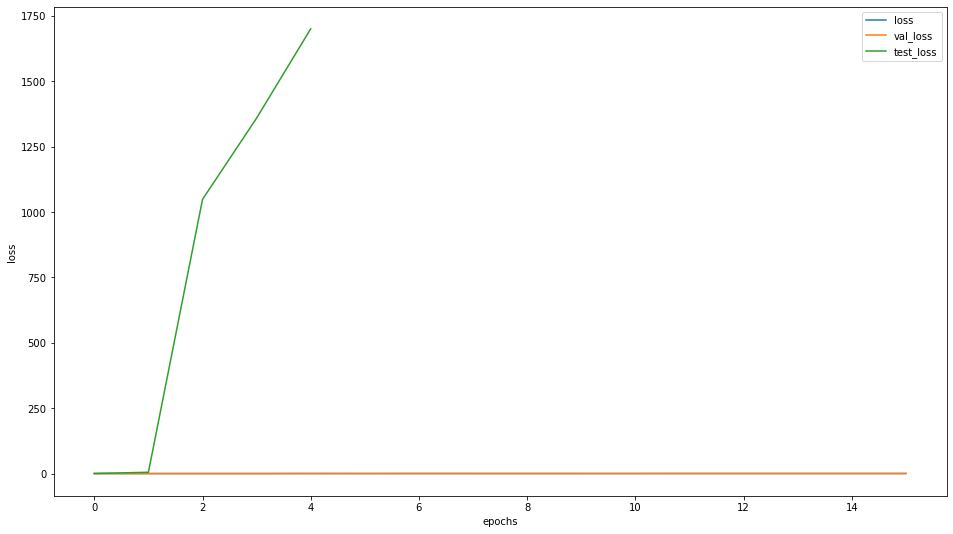

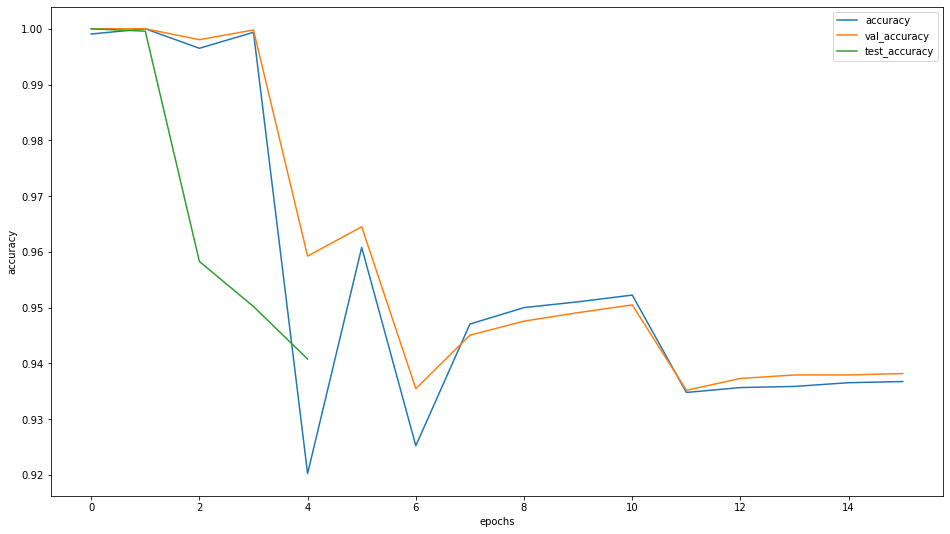

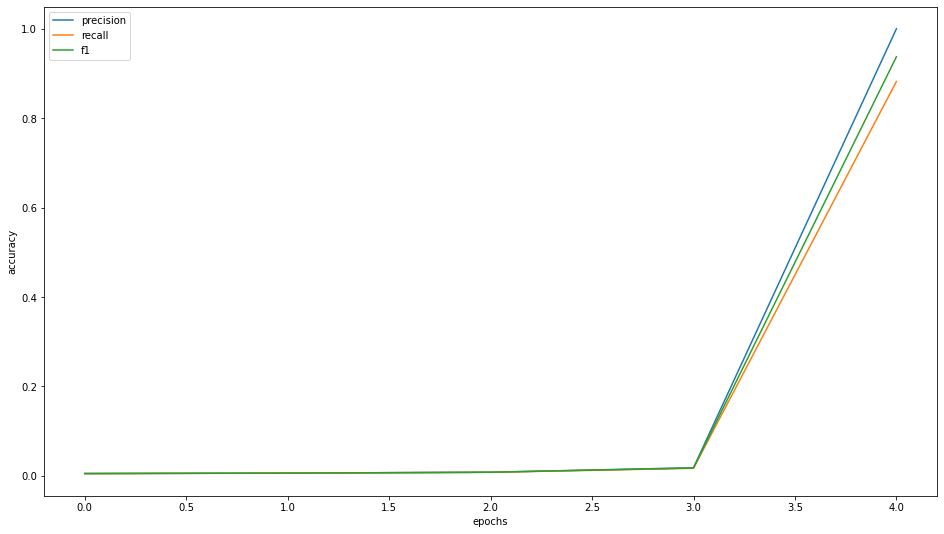

In [5]:
import matplotlib.pyplot as plt

#epochs = len(hist.history['loss'][9:])
plt.figure(figsize=(16, 9))
plt.plot(range(len(train_loss)), train_loss, label='loss')
plt.plot(range(len(val_loss)), val_loss, label='val_loss')
plt.plot(range(len(test_loss)), test_loss, label='test_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(range(len(train_acc)), train_acc, label='accuracy')
plt.plot(range(len(val_acc)), val_acc, label='val_accuracy')
plt.plot(range(len(test_acc)), test_acc, label='test_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()


plt.figure(figsize=(16, 9))
plt.plot(range(len(test_p)), test_p, label='precision')
plt.plot(range(len(test_r)), test_r, label='recall')
plt.plot(range(len(test_f)), test_f, label='f1')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()


In [1]:
import pandas as pd
import os
import sys
#import warnings
#warnings.filterwarnings('ignore')
class Pipeline:
    def __init__(self,  ratio, root, language):
        self.ratio = ratio
        self.root = root
        self.language = language
        self.sources = None
        self.blocks = None
        self.pairs = None
        self.train_file_path = None
        self.dev_file_path = None
        self.test_file_path = None
        self.size = None
        
        self.seen_ids = None
        self.unseen_ids = None

    # parse source code
    def parse_source(self, output_file, option):
        path = self.root+self.language+'/'+output_file
        if os.path.exists(path) and option == 'existing':
            source = pd.read_pickle(path)
        else:
            if self.language == 'c':
                from pycparser import c_parser
                parser = c_parser.CParser()
                source = pd.read_pickle(self.root+self.language+'/programs.pkl')
                source.columns = ['id', 'code', 'label']
                source['code'] = source['code'].apply(parser.parse)
                source.to_pickle(path)
            else:
                import javalang
                def parse_program(func):
                    tokens = javalang.tokenizer.tokenize(func)
                    parser = javalang.parser.Parser(tokens)
                    tree = parser.parse_member_declaration()
                    return tree
                source = pd.read_csv(self.root+self.language+'/bcb_funcs_all.tsv', sep='\t', header=None, encoding='utf-8')
                source.columns = ['id', 'code']
                source.loc[15167, 'code'] = source['code'][15167]+'\r     */'
                source['code'] = source['code'].apply(parse_program)
                source.to_pickle(path)
        self.sources = source
        return source

    # create clone pairs
    def read_pairs(self, filename):
        pairs = pd.read_pickle(self.root+self.language+'/'+filename)
        self.pairs = pairs

    # split data for training, developing and testing
    def split_data(self):
        data_path = self.root+self.language+'/'
        data = self.pairs
        data_num = len(data)
        ratios = [int(r) for r in self.ratio.split(':')]
        train_split = int(ratios[0]/sum(ratios)*data_num)
        val_split = train_split + int(ratios[1]/sum(ratios)*data_num)

        data = data.sample(frac=1, random_state=666)
        train = data.iloc[:train_split]
        dev = data.iloc[train_split:val_split]
        test = data.iloc[val_split:]
        # 好像这里并没能保证 train 和 test 不相交

        def check_or_create(path):
            if not os.path.exists(path):
                os.mkdir(path)
        train_path = data_path+'train/'
        check_or_create(train_path)
        self.train_file_path = train_path+'train_.pkl'
        train.to_pickle(self.train_file_path)

        dev_path = data_path+'dev/'
        check_or_create(dev_path)
        self.dev_file_path = dev_path+'dev_.pkl'
        dev.to_pickle(self.dev_file_path)

        test_path = data_path+'test/'
        check_or_create(test_path)
        self.test_file_path = test_path+'test_.pkl'
        test.to_pickle(self.test_file_path)
        
        train_ids = train['id1'].append(train['id2']).unique()
        dev_ids = dev['id1'].append(dev['id2']).unique()
        test_ids = test['id1'].append(test['id2']).unique()
        
        import numpy as np
        self.seen_ids = np.unique(np.hstack([train_ids, dev_ids]))
        self.unseen_ids = np.setdiff1d(self.sources['id'].unique(), self.seen_ids)

    # construct dictionary and train word embedding
    def dictionary_and_embedding(self, input_file, size):
        self.size = size
        data_path = self.root+self.language+'/'
        if not input_file:
            input_file = self.train_file_path
        pairs = pd.read_pickle(input_file)
        train_ids = pairs['id1'].append(pairs['id2']).unique()

        temp = self.sources.set_index('id',drop=False)
        trees = temp.loc[temp.index.intersection(train_ids)]
        if not os.path.exists(data_path+'train/embedding'):
            os.mkdir(data_path+'train/embedding')
        if self.language == 'c':
            sys.path.append('../')
            from prepare_data import get_sequences as func
        else:
            from utils import get_sequence as func

        def trans_to_sequences(ast):
            sequence = []
            func(ast, sequence)
            return sequence
        corpus = trees['code'].apply(trans_to_sequences)
        str_corpus = [' '.join(c) for c in corpus]
        trees['code'] = pd.Series(str_corpus)
        # trees.to_csv(data_path+'train/programs_ns.tsv')

        from gensim.models.word2vec import Word2Vec
        w2v = Word2Vec(corpus, size=size, workers=16, sg=1, max_final_vocab=3000)
        w2v.save(data_path+'train/embedding/node_w2v_' + str(size))

    # generate block sequences with index representations
    def generate_block_seqs(self):
        if self.language == 'c':
            from prepare_data import get_blocks as func
        else:
            from utils import get_blocks_v1 as func
        from gensim.models.word2vec import Word2Vec

        word2vec = Word2Vec.load(self.root+self.language+'/train/embedding/node_w2v_' + str(self.size)).wv
        vocab = word2vec.vocab
        max_token = word2vec.vectors.shape[0]

        def tree_to_index(node):
            token = node.token
            result = [vocab[token].index if token in vocab else max_token]
            children = node.children
            for child in children:
                result.append(tree_to_index(child))
            return result

        def trans2seq(r):
            blocks = []
            func(r, blocks)
            tree = []
            for b in blocks:
                btree = tree_to_index(b)
                tree.append(btree)
            return tree
        trees = pd.DataFrame(self.sources, copy=True)
        trees['code'] = trees['code'].apply(trans2seq)
        if 'label' in trees.columns:
            trees.drop('label', axis=1, inplace=True)
        self.blocks = trees

    # merge pairs
    def merge(self,data_path,part):
        pairs = pd.read_pickle(data_path)
        pairs['id1'] = pairs['id1'].astype(int)
        pairs['id2'] = pairs['id2'].astype(int)
        df = pd.merge(pairs, self.blocks, how='left', left_on='id1', right_on='id')
        df = pd.merge(df, self.blocks, how='left', left_on='id2', right_on='id')
        df.drop(['id_x', 'id_y'], axis=1,inplace=True)
        df.dropna(inplace=True)

        df.to_pickle(self.root+self.language+'/'+part+'/blocks.pkl')

        
    def generate_query_source(self):
        self.sources['block'] = self.blocks['code']
        self.sources.drop(columns=['code'], axis=1, inplace=True)
        self.sources = self.sources.set_index('id')
        self.query_source = self.sources.loc[self.sources.index.intersection(self.seen_ids)]
        self.unseen_source = self.sources.loc[self.sources.index.intersection(self.unseen_ids)]
        self.query_source.to_pickle(self.root+self.language+'/query_source.pkl')
        self.unseen_source.to_pickle(self.root+self.language+'/unseen_source.pkl')
        
    # run for processing data to train
    def run(self):
        print('parse source code...')
        self.parse_source(output_file='ast.pkl',option='existing')
        print('read id pairs...')
        if self.language == 'c':
            self.read_pairs('oj_clone_ids.pkl')
        else:
            self.read_pairs('bcb_pair_ids.pkl')
        print('split data...')
        self.split_data()
        print('train word embedding...')
        self.dictionary_and_embedding(None,128)
        print('generate block sequences...')
        self.generate_block_seqs()
        print('merge pairs and blocks...')
        self.merge(self.train_file_path, 'train')
        self.merge(self.dev_file_path, 'dev')
        self.merge(self.test_file_path, 'test')
        print('generate query source...')
        self.generate_query_source()


ppl = Pipeline('3:1:1', 'data/', 'java')
ppl.run()

parse source code...
read id pairs...
split data...
train word embedding...
generate block sequences...
merge pairs and blocks...
generate query source...
